In [5]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import os
import numpy as np
% matplotlib inline

In [6]:
files = os.listdir("camera_cal/")

In [7]:
n_width_point = 9
n_height_point = 6

objp = np.zeros((n_width_point*n_height_point,3),np.float32)
objp[:,:2] = np.mgrid[0:n_width_point,0:n_height_point].T.reshape(-1,2)
objpoints = []
imgpoints = []

for filename in files:
    
    path = "camera_cal/" + filename
    img = cv2.imread(path)
   
    # convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # find corners
    ret,corners = cv2.findChessboardCorners(gray,(n_width_point,n_height_point),None)
    
    # If found, add object points, image points
    if ret == True:
        print(filename)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (n_width_point,n_height_point), corners, ret)
        
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

calibration10.jpg
calibration11.jpg
calibration12.jpg
calibration13.jpg
calibration14.jpg
calibration15.jpg
calibration16.jpg
calibration17.jpg
calibration18.jpg
calibration19.jpg
calibration2.jpg
calibration20.jpg
calibration3.jpg
calibration6.jpg
calibration7.jpg
calibration8.jpg
calibration9.jpg


In [8]:
import pickle

img_size = (1280,720)
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

# Save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle,open("camera_cal/wide_dist_pickle.p", "wb" ))

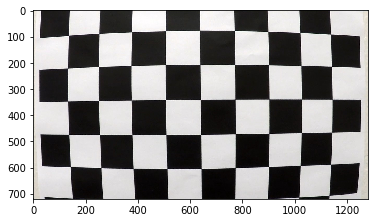

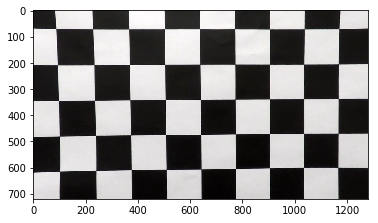

In [9]:
# undistort image
img = mpimg.imread("camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(dst)

In [10]:
# Choose a Sobel kernerl size
ksize = 3

In [11]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply cv2.Sobel
    if orient == 'x':
        sobel = cv2.Sobel(gray,cv2.CV_64F,1,0)
    else:
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary = np.zeros_like(scaled_sobel)
    
    binary[ (scaled_sobel >= thresh_min) & (scaled_sobel < thresh_max)] = 1
    return binary

In [12]:
def mag_thresh(img, sobel_kernel=3, thresh_min=0,thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag = np.sqrt(sobelx**2 + sobely**2)
    scale_mag = np.uint8(mag*255/np.max(mag))
    
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scale_mag)
    binary_output[(scale_mag >= thresh_min) & (scale_mag <= thresh_max)] = 1
    return binary_output

In [13]:
def dir_thresh(img, sobel_kernel=3,thresh_min=0,thresh_max=np.pi/2):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobelx,abs_sobely)
    binary_output = np.zeros_like(direction)
    binary_output[(direction >= thresh_min) & (direction <= thresh_max)] = 1
    return binary_output

In [14]:
def sat_thresh(img,thresh_min,thresh_max):
    # convert to HLS
    hls = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel>=thresh_min) & (s_channel <=thresh_max) ] = 1
    return binary_output

In [15]:
files = os.listdir('test_images/')

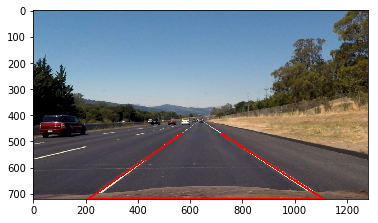

In [17]:
test_image = mpimg.imread('test_images/straight_lines2.jpg')
undist = cv2.undistort(test_image,mtx,dist,None,mtx)
pts = np.array([[210,720],[570,470],[720,470],[1110,720]])
cv2.polylines(undist,np.int32([pts]),1,(255,0,0),5)
plt.imshow(undist)

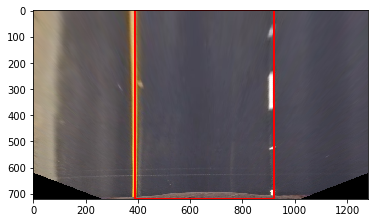

In [18]:
# find perspective matrix
test_image = mpimg.imread('test_images/straight_lines1.jpg')
undist = cv2.undistort(test_image,mtx,dist,None,mtx)
src = np.float32([[210,720],[570,470],[720,470],[1110,720]])
dst = np.float32([[390,720],[390,0],[920,0],[920,720]])
M = cv2.getPerspectiveTransform(src,dst)
warp = cv2.warpPerspective(undist,M,(test_image.shape[1],test_image.shape[0]))
cv2.polylines(warp,np.int32([[[390,720],[390,0],[920,0],[920,720]]]),1,(255,0,0),5)
plt.figure()
plt.imshow(warp)

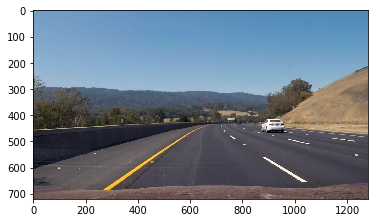

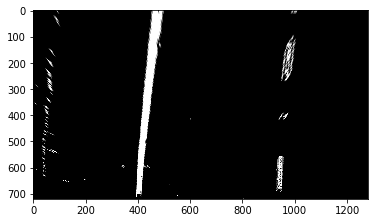

In [118]:
path = 'test_images/test3.jpg'
test_image = mpimg.imread(path)

plt.figure()
plt.imshow(test_image)

    # undistort image
dst = cv2.undistort(test_image,mtx,dist,None,mtx)
    #plt.figure()
    #plt.imshow(dst)

mag_binary = mag_thresh(dst,15,50,150)
   


dir_binary = dir_thresh(dst,15,0.3,1.7)

color_binary = sat_thresh(test_image,170,255)
   

combine = np.zeros_like(dir_binary)
combine[((dir_binary==1) & (mag_binary==1)) | (color_binary==1) ] = 1


    
# Apply a perspective transform to rectify binary image
warp = cv2.warpPerspective(combine,M,(test_image.shape[1],test_image.shape[0]))
#out_img = np.dstack((warp, warp, warp))*255
#cv2.polylines(out_img,np.int32([[[390,720],[390,0],[920,0],[920,720]]]),1,(255,0,0),5)
plt.figure()
plt.imshow(warp,cmap='gray')

In [131]:
# Detect lane pixels and fit to find the lane boundary
n_windows = 9
window_height = 80

min_pix = 50
def detect_and_fit(gray):
    left_current = 390
    right_current = 920
    out_img = np.dstack((gray,gray,gray))*255
    out_img = np.uint8(out_img)
    nonzero = np.nonzero(gray)
    nonzerox = nonzero[1]
    nonzeroy = nonzero[0]
    margin = 100
    left_lane = []
    right_lane = []
    for window in range(n_windows):
        win_y_min = gray.shape[0] - (window + 1) * window_height
        win_y_max = gray.shape[0] - (window) * window_height
        win_x_left_min = left_current - margin 
        win_x_left_max = left_current + margin
        win_x_right_min = right_current - margin
        win_x_right_max = right_current + margin
        # Draw the windows on the visualization image
       
        cv2.rectangle(out_img,(win_x_left_min,win_y_min),(win_x_left_max,win_y_max),(0,255,0),4)
        cv2.rectangle(out_img,(win_x_right_min,win_y_min),(win_x_right_max,win_y_max),(0,255,0),4)
        #plt.figure()
        #plt.imshow(out_img)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzerox >= win_x_left_min) & (nonzerox < win_x_left_max) \
            & (nonzeroy >= win_y_min) & (nonzeroy < win_y_max)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_x_right_min) & (nonzerox < win_x_right_max) \
            & (nonzeroy >= win_y_min) & (nonzeroy < win_y_max)).nonzero()[0]
        left_lane.append(good_left_inds)
        right_lane.append(good_right_inds)
        if (len(good_left_inds) > min_pix):
            left_current = np.int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > min_pix):
            right_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane = np.concatenate(left_lane)
    right_lane = np.concatenate(right_lane)
    left_lane_x = nonzerox[left_lane]
    left_lane_y = nonzeroy[left_lane]
    right_lane_x = nonzerox[right_lane]
    right_lane_y = nonzeroy[right_lane]
    left_fit = np.polyfit(left_lane_y,left_lane_x,2)
    right_fit = np.polyfit(right_lane_y,right_lane_x,2)
    
    ploty = np.linspace(0, gray.shape[0]-1, gray.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

[  3.95174040e-05  -1.35417316e-01   4.76807959e+02]


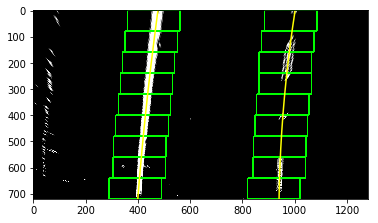

In [132]:
detect_and_fit(warp)

In [ ]:
for image in files:
    
    path = 'test_images/' + image 
    test_image = mpimg.imread(path)

    plt.figure()
    plt.imshow(test_image)

    # undistort image
    dst = cv2.undistort(test_image,mtx,dist,None,mtx)
    #plt.figure()
    #plt.imshow(dst)

    mag_binary = mag_thresh(dst,15,50,150)
    #plt.imshow(mag_binary,cmap='gray')


    dir_binary = dir_thresh(dst,15,0.3,1.7)
    #plt.imshow(dir_binary,cmap='gray')

    #combine = np.zeros_like(dir_binary)
    #combine[(dir_binary==1) & (mag_binary==1)] = 1
    #plt.imshow(combine,cmap='gray')

    # Threshold color channel
    color_binary = sat_thresh(test_image,170,255)
    #plt.imshow(color_binary,cmap='gray')

    combine = np.zeros_like(dir_binary)
    combine[((dir_binary==1) & (mag_binary==1)) | (color_binary==1) ] = 1
    #plt.figure()
    #plt.imshow(combine,cmap='gray')
    
    # Apply a perspective transform to rectify binary image
    warp = cv2.warpPerspective(combine,M,(test_image.shape[1],test_image.shape[0]))
    plt.figure()
    plt.imshow(warp,cmap='gray')

